In [1]:
library(caret)
library(e1071)
library(randomForest)
library(ROCR)
library(dplyr)
library(tidyr)
library(rpart)
library(gbm)
library(pROC)
library(ggplot2) 
library(kernlab) 
library(car)
library(lattice)
library(purrr)

Loading required package: ggplot2



Loading required package: lattice

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loaded gbm 2.1.8.1

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode



Attaching package: 'purrr'


The following object is masked from 'package:car':

    some


The following o

In [2]:
# Data loading
data <- read.csv("C:\\Users\\user\\Desktop\\DataProject\\Data\\heart.csv", fileEncoding = "UTF-8") 

# Convert HeartDisease variable
data$HeartDisease <- ifelse(data$HeartDisease == 0, "NoDisease", "HasDisease")
data$HeartDisease <- as.factor(data$HeartDisease)

# List of categorical variables for dummy variable creation
categorical_vars <- c("Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope")

# Creation of dummy variables
dummies <- dummyVars(~ ., data = data[, categorical_vars])
data_categorical_encoded <- predict(dummies, newdata = data[, categorical_vars])
data_categorical_encoded <- as.data.frame(data_categorical_encoded) 

# Keeping continuous variables as they are
continuous_vars <- c("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
data_continuous <- data[, continuous_vars]

# Combine categorical dummy variables and continuous variables
data_encoded <- cbind(data_categorical_encoded, data_continuous)
data_encoded$HeartDisease <- data$HeartDisease

# Splitting Train/Test data
set.seed(123)
splitIndex <- createDataPartition(data_encoded$HeartDisease, p = 0.8, list = TRUE)
trainData <- data_encoded[splitIndex$Resample1, ]
testData <- data_encoded[-splitIndex$Resample1, ] 


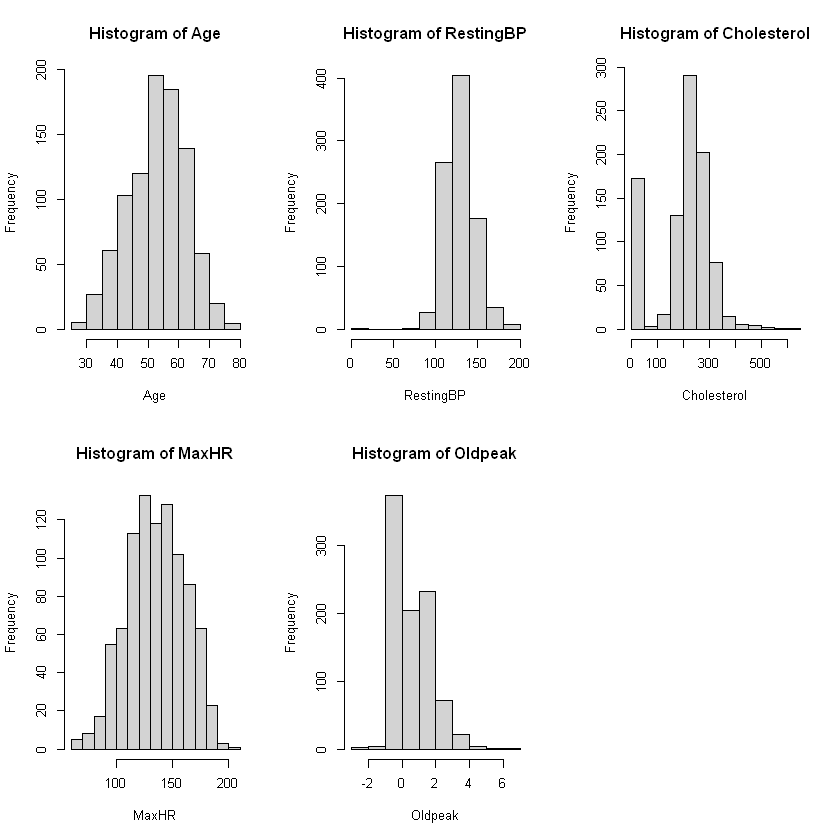

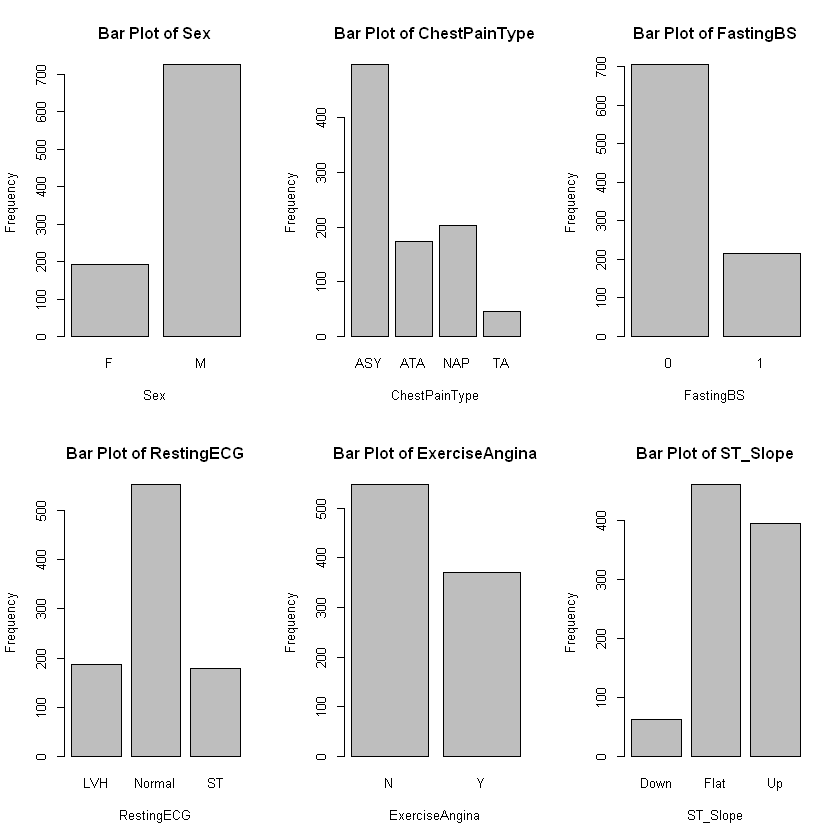

In [3]:
# Reviewing the distribution of continuous variables
continuous_vars <- c("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
par(mfrow=c(2,3))  # Setting graphic parameters to display multiple plots side by side
for(var in continuous_vars) {
    hist(data[[var]], main=paste("Histogram of", var), xlab=var)
}

# Reviewing the distribution of categorical variables
categorical_vars <- c("Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope")
par(mfrow=c(2,3))  # Setting graphic parameters to display multiple plots side by side
for(var in categorical_vars) {
    barplot(table(data[[var]]), main=paste("Bar Plot of", var), xlab=var, ylab="Frequency")
}

        Age.cor   RestingBP.cor Cholesterol.cor       MaxHR.cor     Oldpeak.cor 
     -0.2781588      -0.1168549       0.2167305       0.4110657      -0.4241275 
[1] "Age.cor"         "Cholesterol.cor" "MaxHR.cor"       "Oldpeak.cor"    


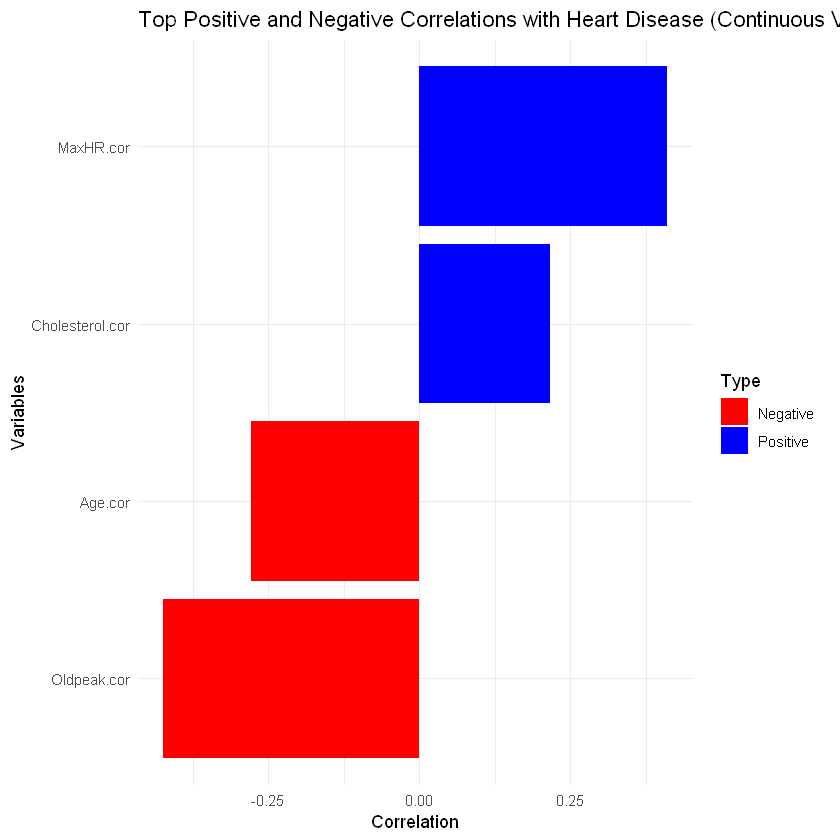

In [4]:
# Calculating Point-Biserial correlation coefficient for continuous variables
continuous_vars <- c("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
cor_values_cont <- sapply(trainData[, continuous_vars], function(x) {
  cor.test(x, as.numeric(trainData$HeartDisease))$estimate
})
print(cor_values_cont)

# Extracting continuous variables with a correlation coefficient of 0.3 or more
high_cor_vars_cont <- names(cor_values_cont)[abs(cor_values_cont) >= 0.2]

# Printing the extracted variables
print(high_cor_vars_cont)

# Extracting continuous variables with a correlation coefficient of 0.5 or more, or -0.5 or less
high_pos_cor_vars_cont <- names(cor_values_cont)[cor_values_cont >= 0.2]
high_neg_cor_vars_cont <- names(cor_values_cont)[cor_values_cont <= -0.2]

# Extracting and sorting correlation coefficients
top_pos_cor_values <- sort(cor_values_cont[high_pos_cor_vars_cont], decreasing = TRUE)
top_neg_cor_values <- sort(cor_values_cont[high_neg_cor_vars_cont])

# Extracting top correlation coefficients (up to 5 each)
top_pos_cor_values <- head(top_pos_cor_values, 5)
top_neg_cor_values <- head(top_neg_cor_values, 5)

# Creating a data frame
top_cor_df <- data.frame(
  Variable = c(names(top_pos_cor_values), names(top_neg_cor_values)),
  Correlation = c(top_pos_cor_values, top_neg_cor_values),
  Type = rep(c("Positive", "Negative"), times = c(length(top_pos_cor_values), length(top_neg_cor_values)))
)

# Visualizing correlation coefficients
ggplot(top_cor_df, aes(x = reorder(Variable, Correlation), y = Correlation, fill = Type)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Display bars horizontally
  labs(title = "Top Positive and Negative Correlations with Heart Disease (Continuous Variables)", x = "Variables", y = "Correlation") +
  scale_fill_manual(values = c("Positive" = "blue", "Negative" = "red")) +
  theme_minimal() 

Chi-squared test results:


                         Variable Chi2_p_value
ST_SlopeUp             ST_SlopeUp 1.195598e-67
ST_SlopeFlat         ST_SlopeFlat 2.945221e-53
ChestPainTypeASY ChestPainTypeASY 1.449545e-44
ExerciseAnginaN   ExerciseAnginaN 8.665947e-41
ExerciseAnginaY   ExerciseAnginaY 8.665947e-41
ChestPainTypeATA ChestPainTypeATA 1.878141e-29
SexF                         SexF 2.754959e-16
SexM                         SexM 2.754959e-16
FastingBS               FastingBS 7.594531e-12
ChestPainTypeNAP ChestPainTypeNAP 2.248488e-08
ST_SlopeDown         ST_SlopeDown 7.054600e-04
RestingECGST         RestingECGST 1.077070e-02
RestingECGNormal RestingECGNormal 1.611031e-02
ChestPainTypeTA   ChestPainTypeTA 4.025645e-01
RestingECGLVH       RestingECGLVH 7.747959e-01

Fisher's exact test results (where applicable):
                         Variable Fisher_p_value
ST_SlopeUp             ST_SlopeUp   1.130199e-72
ST_SlopeFlat         ST_SlopeFlat   1.277198e-56
ChestPainTypeASY ChestPainTypeASY   9.579331e-47
Exe

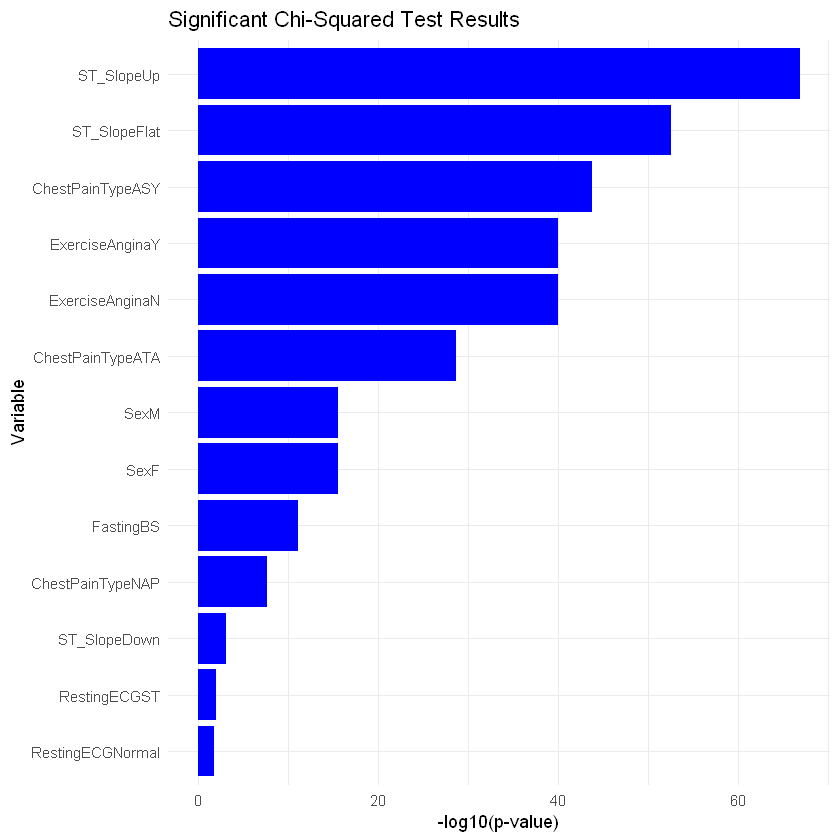

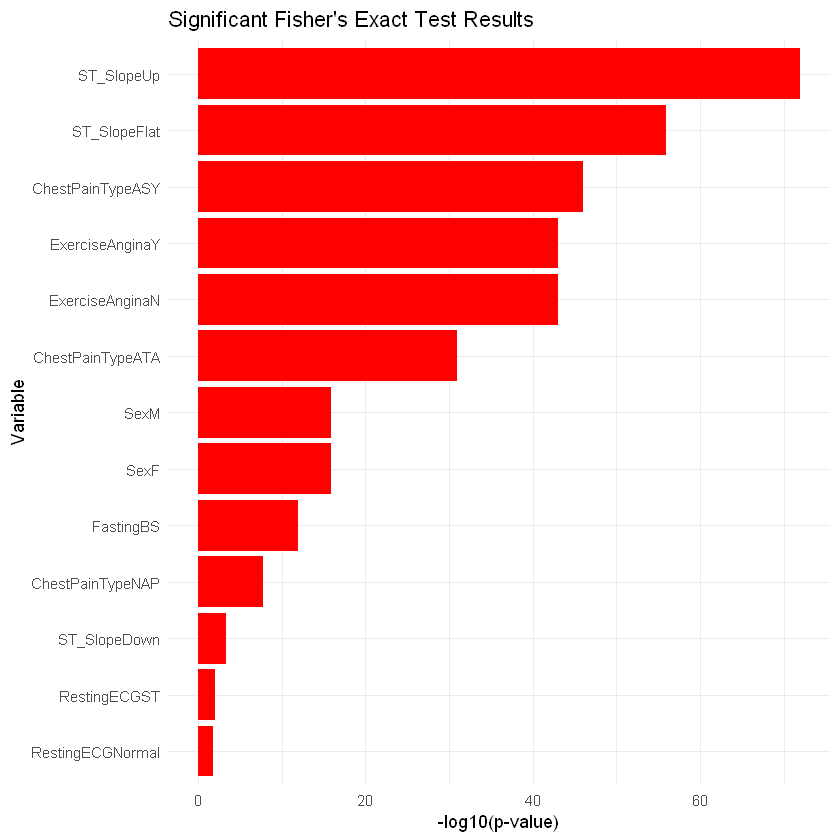

In [5]:
# Updating the list of categorical variables
categorical_vars <- c("SexF", "SexM", "ChestPainTypeASY", "ChestPainTypeATA", "ChestPainTypeNAP", "ChestPainTypeTA", "FastingBS", "RestingECGLVH", "RestingECGNormal", "RestingECGST", "ExerciseAnginaN", "ExerciseAnginaY", "ST_SlopeDown", "ST_SlopeFlat", "ST_SlopeUp")

# Function to perform Chi-squared and Fisher's exact tests
perform_tests <- function(data, categorical_vars) {
  chi2_results <- list()
  fisher_results <- list()
  
  for (var in categorical_vars) {
    # Creating contingency table
    contingency_table <- table(data[[var]], data$HeartDisease)
    
    # Chi-squared test
    chi2_test <- chisq.test(contingency_table)
    chi2_results[[var]] <- chi2_test$p.value
    
    # Fisher's exact test is only possible for 2x2 tables
    if (all(dim(contingency_table) == c(2, 2))) {
      fisher_test <- fisher.test(contingency_table)
      fisher_results[[var]] <- fisher_test$p.value
    } else {
      fisher_results[[var]] <- NA  # Assign NA if not a 2x2 table
    }
  }
  
  # Converting results to data frames
  chi2_df <- data.frame(Variable = names(chi2_results), Chi2_p_value = unlist(chi2_results))
  fisher_df <- data.frame(Variable = names(fisher_results), Fisher_p_value = unlist(fisher_results))
  
  list(chi2 = chi2_df, fisher = fisher_df)
}

# Performing the tests
test_results <- perform_tests(trainData, categorical_vars)

# Printing Chi-squared test results
cat("Chi-squared test results:\n")
print(test_results$chi2 %>% arrange(Chi2_p_value))

# Printing Fisher's exact test results (where applicable)
cat("\nFisher's exact test results (where applicable):\n")
print(test_results$fisher %>% arrange(Fisher_p_value)) 

# Filtering variables with p-value less than 0.05
significant_chi2 <- test_results$chi2 %>% 
  filter(Chi2_p_value < 0.05)

# Visualizing significant Chi-squared test results
ggplot(significant_chi2, aes(x = reorder(Variable, -Chi2_p_value), y = -log10(Chi2_p_value))) +
  geom_col(fill = "blue") +
  coord_flip() +
  labs(title = "Significant Chi-Squared Test Results",
       x = "Variable",
       y = "-log10(p-value)") +
  theme_minimal()

# Including Fisher's test results with p-value less than 0.05 (where applicable)
significant_fisher <- test_results$fisher %>% 
  filter(!is.na(Fisher_p_value) & Fisher_p_value < 0.05)

# Visualizing significant Fisher's test results (where applicable)
if (nrow(significant_fisher) > 0) {
  ggplot(significant_fisher, aes(x = reorder(Variable, -Fisher_p_value), y = -log10(Fisher_p_value))) +
    geom_col(fill = "red") +
    coord_flip() +
    labs(title = "Significant Fisher's Exact Test Results",
         x = "Variable",
         y = "-log10(p-value)") +
    theme_minimal()
}

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misl

     (Intercept)             SexF             SexM ChestPainTypeASY 
     1.377874030      1.911346365               NA     -1.486384535 
ChestPainTypeATA ChestPainTypeNAP  ChestPainTypeTA        FastingBS 
     0.608611751      0.318278419               NA     -1.096540330 
   RestingECGLVH RestingECGNormal     RestingECGST  ExerciseAnginaN 
    -0.381042250     -0.264616048               NA      0.907993146 
 ExerciseAnginaY     ST_SlopeDown     ST_SlopeFlat       ST_SlopeUp 
              NA     -1.323089505     -2.655846477               NA 
             Age        RestingBP      Cholesterol            MaxHR 
    -0.015976749     -0.001630080      0.003193165      0.004814809 
         Oldpeak 
    -0.330153221 

Logistic Regression Coefficients (All Variables):
     (Intercept)             SexF             SexM ChestPainTypeASY 
     1.377874030      1.911346365               NA     -1.486384535 
ChestPainTypeATA ChestPainTypeNAP  ChestPainTypeTA        FastingBS 
     0.608611751

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


                    Precision    Recall  F1 Score
Logistic Regression 0.8461538 0.8712871 0.8585366
Decision Tree       0.7981651 0.8613861 0.8285714
k-NN                0.7264151 0.7623762 0.7439614
Random Forest       0.8490566 0.8910891 0.8695652
Gradient Boosting   0.8653846 0.8910891 0.8780488
SVM                 0.8285714 0.8613861 0.8446602


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


                Model       AUC
1 Logistic Regression 0.9078725
2       Decision Tree 0.8228689
3                k-NN 0.7779522
4       Random Forest 0.9092007
5   Gradient Boosting 0.9184979
6                 SVM 0.9020768
Model: Logistic Regression 
glm variable importance

                 Overall
ST_SlopeFlat     100.000
SexF              63.487
FastingBS         36.548
ExerciseAnginaN   34.902
ChestPainTypeASY  31.693
ST_SlopeDown      26.893
Cholesterol       26.855
Oldpeak           24.285
ChestPainTypeATA   9.845
Age                9.602
RestingECGLVH      8.241
MaxHR              6.933
RestingECGNormal   6.710
ChestPainTypeNAP   4.580
RestingBP          0.000

Model: Decision Tree 
rpart variable importance

                 Overall
ST_SlopeUp       100.000
ChestPainTypeASY  94.281
ExerciseAnginaN   82.141
ST_SlopeFlat      78.216
ExerciseAnginaY   76.760
Cholesterol       16.844
Oldpeak           15.317
SexF              11.251
SexM              11.251
FastingBS          7.91

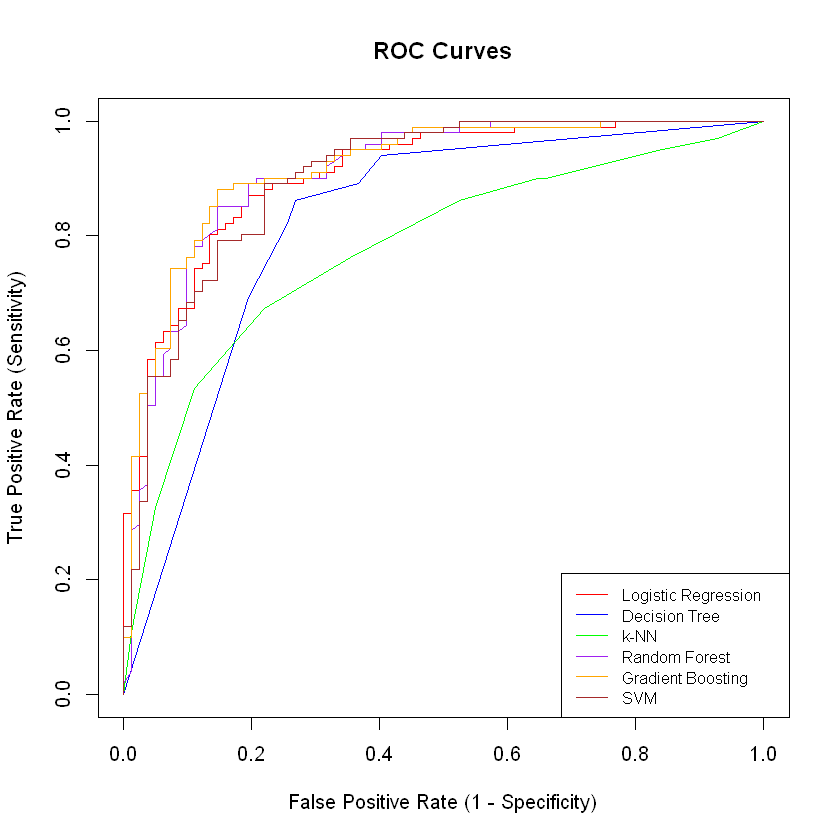

In [6]:
# Categorical dummies + continuous variables
ctrl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
models <- list(
  "Logistic Regression" = train(HeartDisease ~ ., data = trainData, method = "glm", trControl = ctrl, metric = "ROC"),
  "Decision Tree" = train(HeartDisease ~ ., data = trainData, method = "rpart", trControl = ctrl, metric = "ROC"),
  "k-NN" = train(HeartDisease ~ ., data = trainData, method = "knn", trControl = ctrl, metric = "ROC"),
  "Random Forest" = train(HeartDisease ~ ., data = trainData, method = "rf", trControl = ctrl, metric = "ROC"),
  "Gradient Boosting" = train(HeartDisease ~ ., data = trainData, method = "gbm", trControl = ctrl, metric = "ROC", verbose = FALSE),
  "SVM" = train(HeartDisease ~ ., data = trainData, method = "svmRadial", trControl = ctrl, metric = "ROC")
)
logistic_model_all_coef <- coef(models$'Logistic Regression'$finalModel)
print(logistic_model_all_coef)
cat("\nLogistic Regression Coefficients (All Variables):\n")
print(logistic_model_all_coef)
metrics <- lapply(models, function(model) {
  prediction <- predict(model, newdata = testData, type = "raw")
  cm <- confusionMatrix(prediction, reference = testData$HeartDisease)
  precision <- cm$byClass['Pos Pred Value']
  recall <- cm$byClass['Sensitivity']
  f1 <- 2 * (precision * recall) / (precision + recall)
  c(Precision = precision, Recall = recall, `F1 Score` = f1)
})
metrics_df <- as.data.frame(do.call(rbind, metrics))
rownames(metrics_df) <- names(models)
colnames(metrics_df) <- c("Precision", "Recall", "F1 Score")
print(metrics_df)
plot_colors <- c("red", "blue", "green", "purple", "orange", "brown")
auc_values <- numeric(length(models))
for(i in seq_along(models)) {
  model <- models[[i]]
  prob <- predict(model, newdata = testData, type = "prob")
  roc_curve <- roc(response=testData$HeartDisease, predictor=prob[,2], levels=c("NoDisease", "HasDisease"), direction=">")
  auc_values[i] <- auc(roc_curve)
  x <- 1 - roc_curve$specificities
  y <- roc_curve$sensitivities
  if(i == 1) {
    plot(x, y, type="l", col=plot_colors[i], xlim=c(0,1), ylim=c(0,1), xlab="False Positive Rate (1 - Specificity)", ylab="True Positive Rate (Sensitivity)", main="ROC Curves")
  } else {
    lines(x, y, col=plot_colors[i])
  }
}
legend("bottomright", legend=names(models), col=plot_colors, lty=1, cex=0.8)
auc_df <- data.frame(Model = names(models), AUC = auc_values)
print(auc_df)
for(model_name in names(models)) {
  model <- models[[model_name]]
  cat("Model:", model_name, "\n")
  if(methods::is(model, "train")) {
    importance <- varImp(model)
    print(importance)
  } else {
    cat("Variable importance not available for this model.\n")
  }
  cat("\n")
}

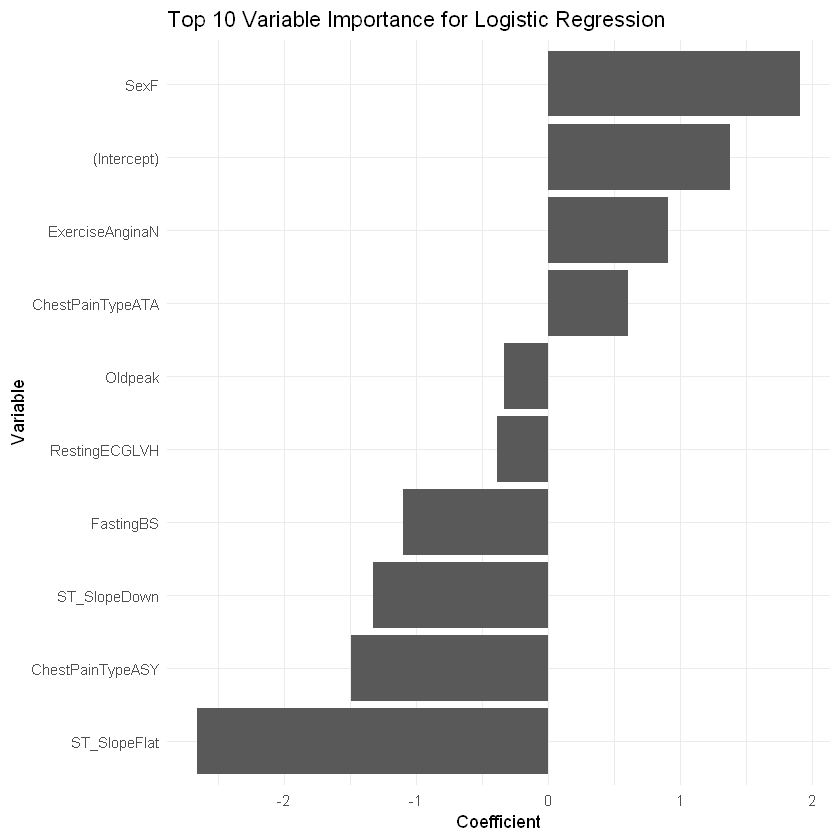

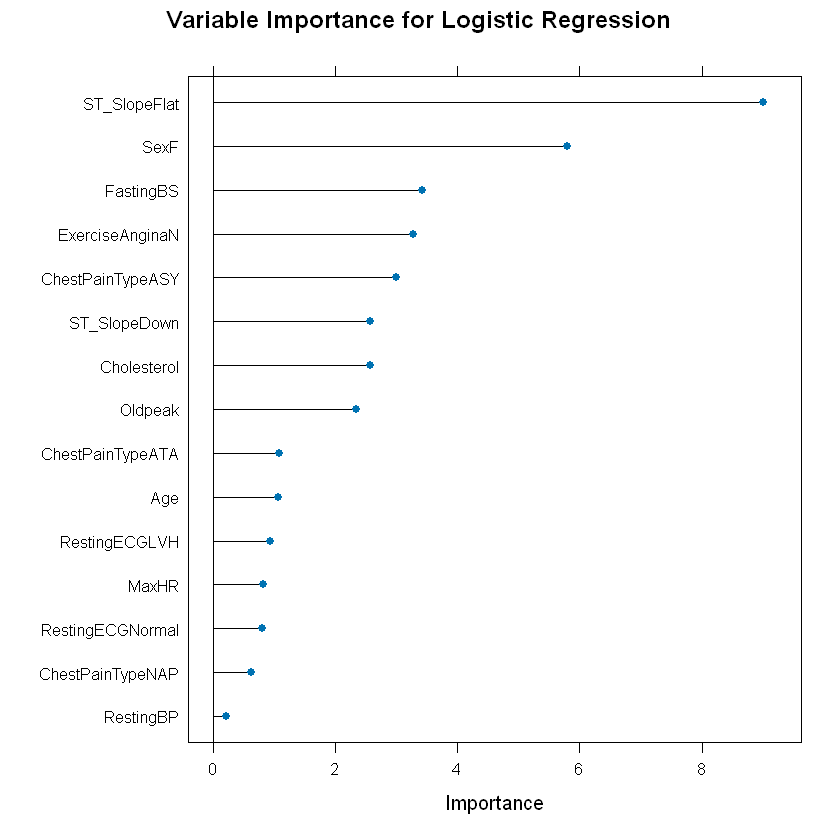

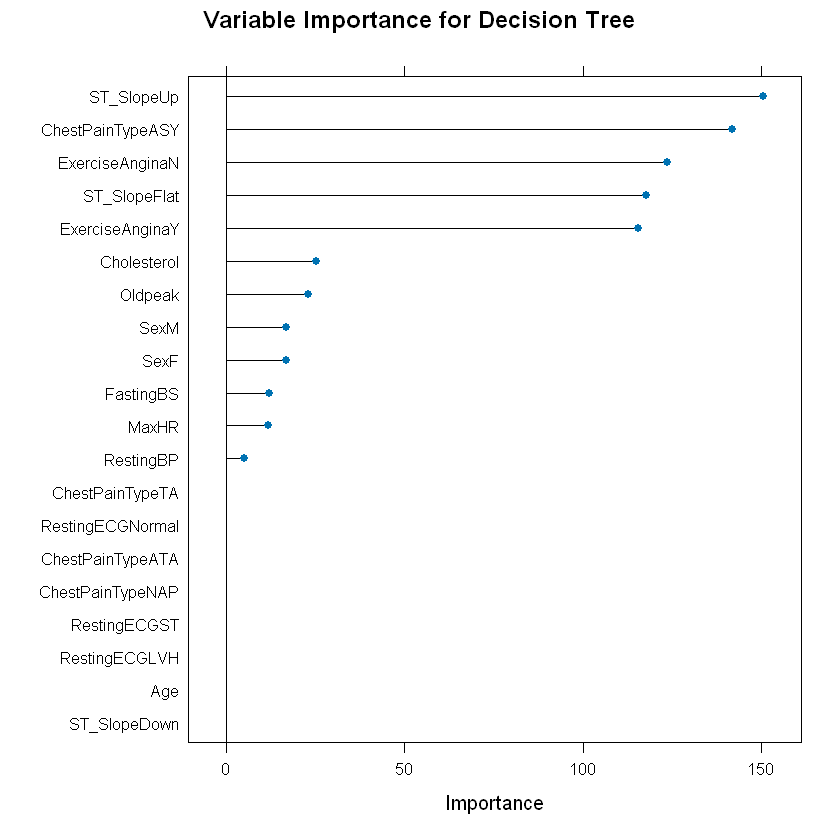

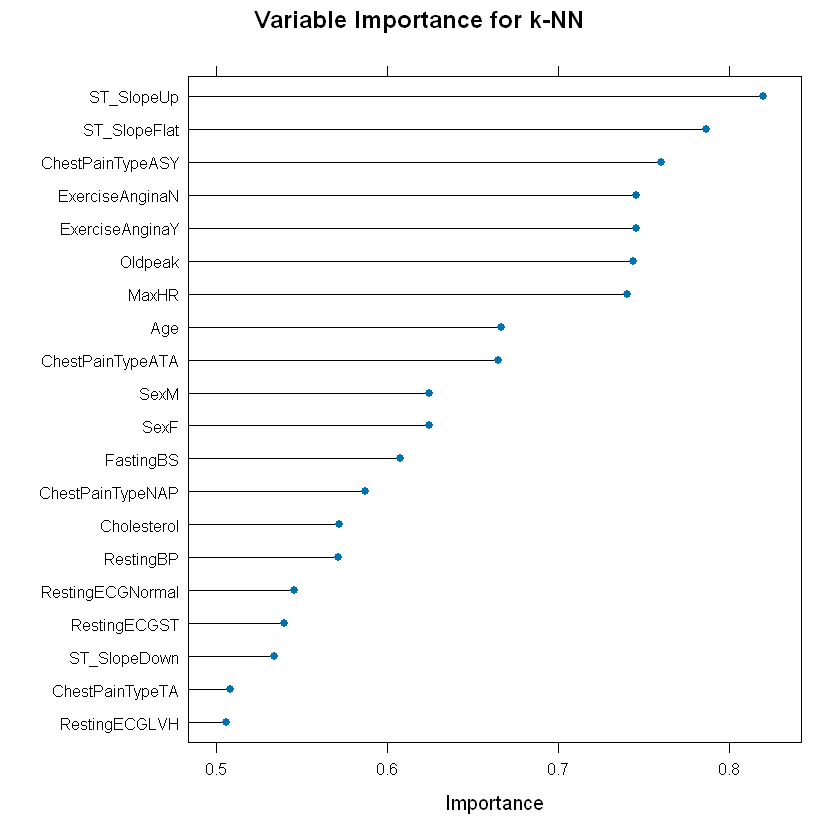

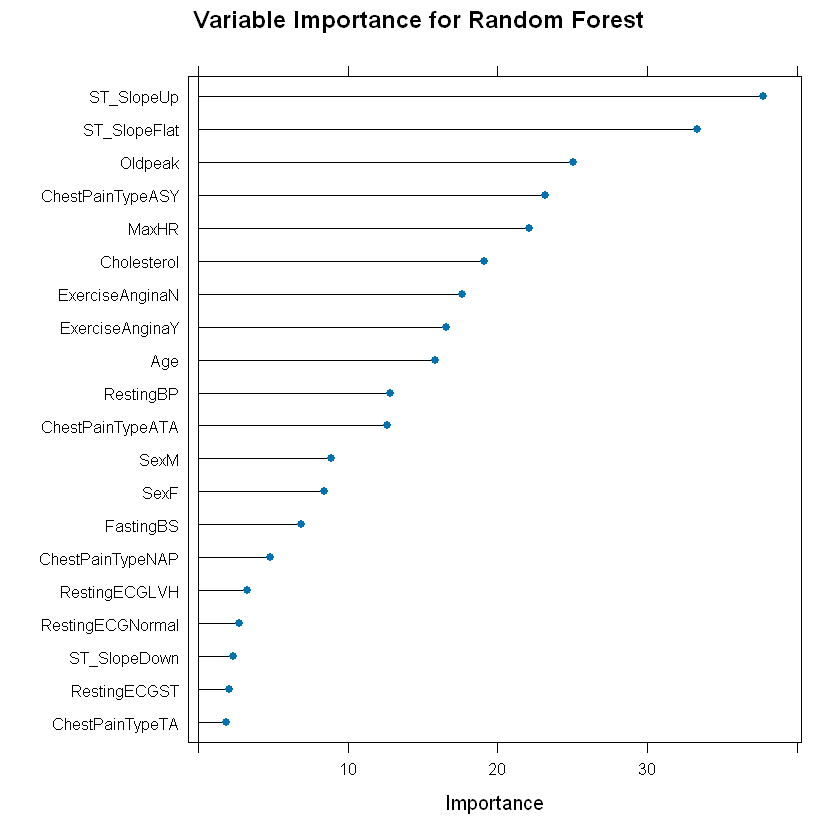

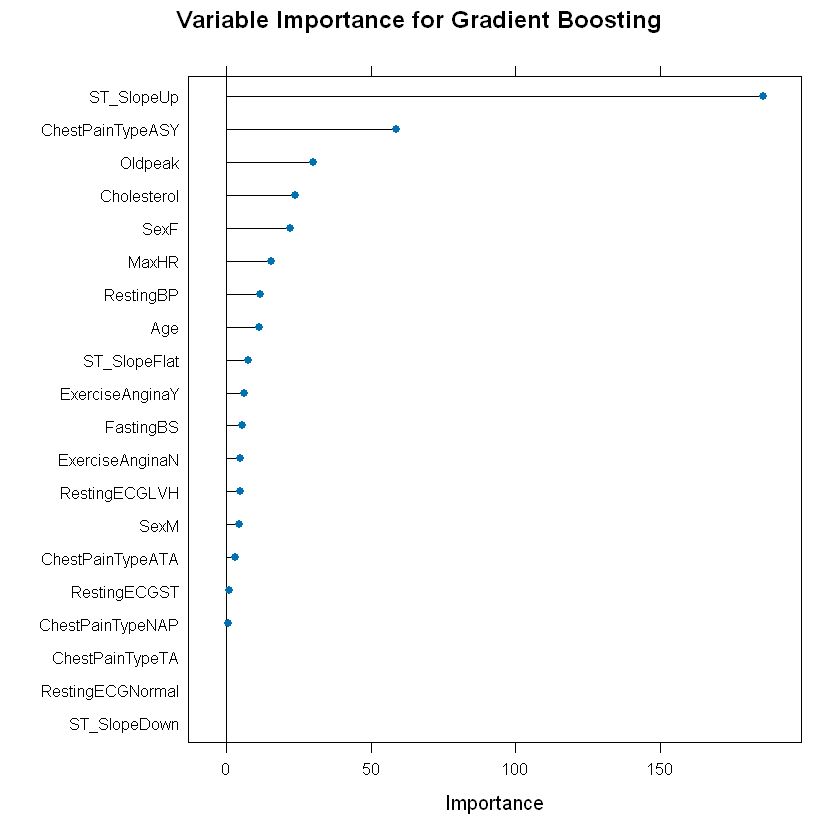

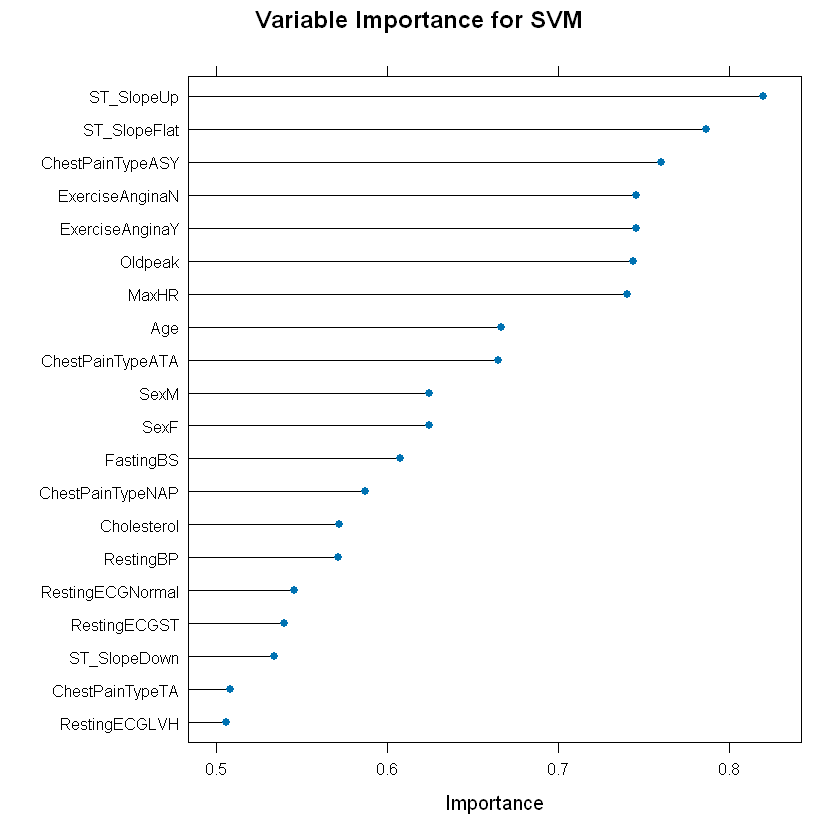

In [7]:
# Logistic Regression 
logistic_importance <- coef(models$'Logistic Regression'$finalModel)
importance_df <- data.frame(
  Variable = names(logistic_importance),
  Coefficient = unname(logistic_importance)
)
top_variables <- importance_df %>%
  arrange(desc(abs(Coefficient))) %>%
  head(10)
ggplot(top_variables, aes(x = reorder(Variable, Coefficient), y = Coefficient)) +
  geom_bar(stat = "identity") + 
  coord_flip() +  
  theme_minimal() + 
  xlab("Variable") + 
  ylab("Coefficient") + 
  ggtitle("Top 10 Variable Importance for Logistic Regression") 

# Logistic Regression 
Logistic_Regression_importance <- varImp(models$'Logistic Regression', scale = FALSE)
plot(Logistic_Regression_importance, main = "Variable Importance for Logistic Regression")

# Decision Tree 
tree_importance <- varImp(models$'Decision Tree', scale = FALSE)
plot(tree_importance, main = "Variable Importance for Decision Tree")

# k-NN 
knn_importance <- varImp(models$'k-NN', scale = FALSE)
plot(knn_importance, main = "Variable Importance for k-NN")

# Random Forest 
rf_importance <- varImp(models$'Random Forest', scale = FALSE)
plot(rf_importance, main = "Variable Importance for Random Forest") 

# Gradient Boosting 
gbm_importance <- varImp(models$'Gradient Boosting', scale = FALSE)
plot(gbm_importance, main = "Variable Importance for Gradient Boosting")

# SVM 
svm_importance <- varImp(models$'SVM', scale = FALSE)
plot(svm_importance, main = "Variable Importance for SVM") 


Start:  AIC=487.02
HeartDisease ~ SexF + SexM + ChestPainTypeASY + ChestPainTypeATA + 
    ChestPainTypeNAP + ChestPainTypeTA + FastingBS + RestingECGLVH + 
    RestingECGNormal + RestingECGST + ExerciseAnginaN + ExerciseAnginaY + 
    ST_SlopeDown + ST_SlopeFlat + ST_SlopeUp + Age + RestingBP + 
    Cholesterol + MaxHR + Oldpeak


Step:  AIC=487.02
HeartDisease ~ SexF + SexM + ChestPainTypeASY + ChestPainTypeATA + 
    ChestPainTypeNAP + ChestPainTypeTA + FastingBS + RestingECGLVH + 
    RestingECGNormal + RestingECGST + ExerciseAnginaN + ExerciseAnginaY + 
    ST_SlopeDown + ST_SlopeFlat + Age + RestingBP + Cholesterol + 
    MaxHR + Oldpeak


Step:  AIC=487.02
HeartDisease ~ SexF + SexM + ChestPainTypeASY + ChestPainTypeATA + 
    ChestPainTypeNAP + ChestPainTypeTA + FastingBS + RestingECGLVH + 
    RestingECGNormal + RestingECGST + ExerciseAnginaN + ST_SlopeDown + 
    ST_SlopeFlat + Age + RestingBP + Cholesterol + MaxHR + Oldpeak


Step:  AIC=487.02
HeartDisease ~ SexF + SexM + Ch

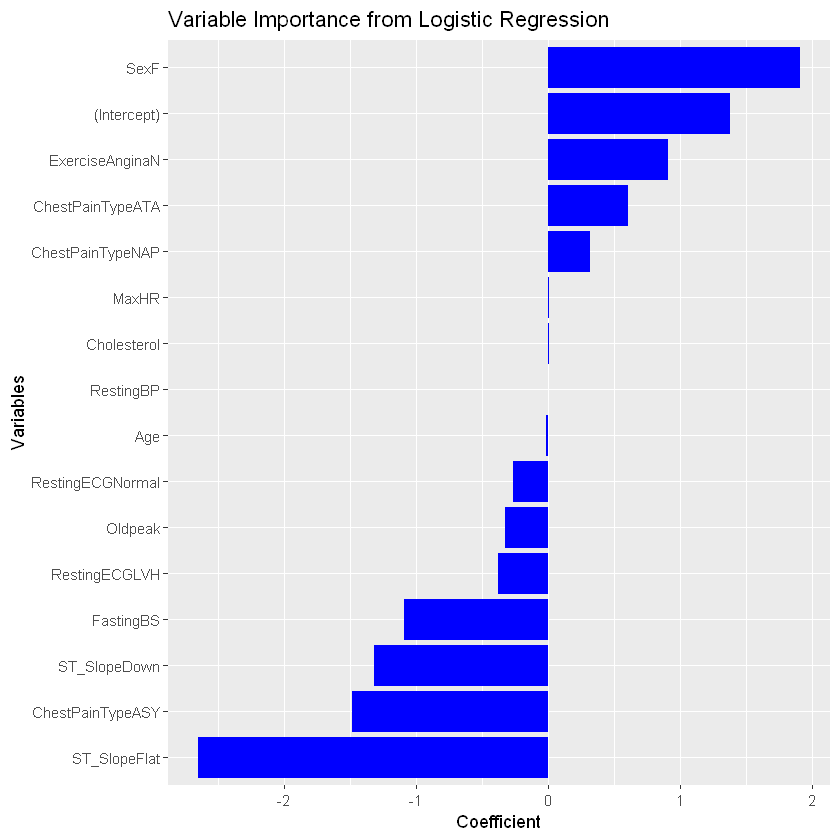


Call:
glm(formula = HeartDisease ~ SexF + ChestPainTypeASY + FastingBS + 
    ExerciseAnginaN + ST_SlopeDown + ST_SlopeFlat + Age + Cholesterol + 
    Oldpeak, family = binomial(), data = trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7658  -0.4204  -0.1653   0.3486   2.7057  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       2.331346   0.848568   2.747 0.006007 ** 
SexF              1.922823   0.326860   5.883 4.04e-09 ***
ChestPainTypeASY -1.887535   0.256344  -7.363 1.79e-13 ***
FastingBS        -1.125029   0.315397  -3.567 0.000361 ***
ExerciseAnginaN   0.890190   0.266165   3.345 0.000824 ***
ST_SlopeDown     -1.376110   0.504902  -2.726 0.006420 ** 
ST_SlopeFlat     -2.750693   0.286017  -9.617  < 2e-16 ***
Age              -0.021251   0.013586  -1.564 0.117783    
Cholesterol       0.003185   0.001165   2.733 0.006280 ** 
Oldpeak          -0.343086   0.138364  -2.480 0.013153 *  
---
Signif. codes:  0 

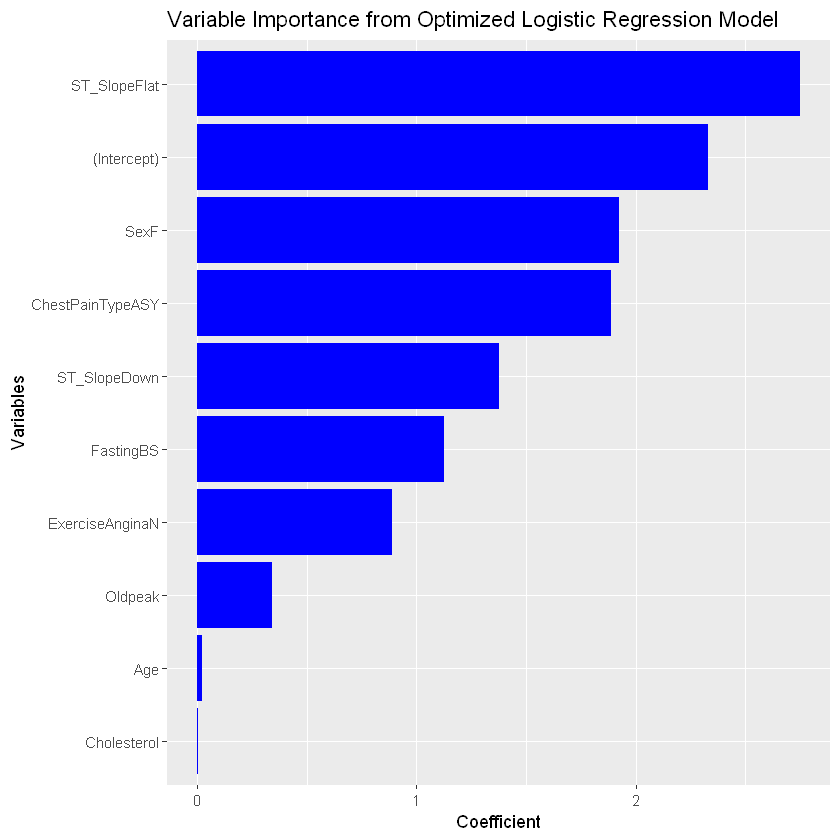

In [8]:
# Fitting the logistic regression model
fit <- glm(HeartDisease ~ ., data = trainData, family = binomial())

# Extracting coefficients from the model summary
coefficients <- summary(fit)$coefficients

# Creating a dataframe based on the importance of coefficients (absolute value)
importance <- as.data.frame(coefficients)[, "Estimate"]
names(importance) <- rownames(coefficients)

# Ordering variables by their importance
importance_ordered <- importance[order(abs(importance), decreasing = TRUE)]

# Visualizing variable importance
importance_df <- data.frame(Variable = names(importance_ordered), Coefficient = importance_ordered)
ggplot(importance_df, aes(x = reorder(Variable, Coefficient), y = Coefficient)) +
  geom_col(fill = 'blue') +
  coord_flip() +
  labs(title = "Variable Importance from Logistic Regression", x = "Variables", y = "Coefficient")

# Optimizing the model using stepwise regression
step_fit <- step(fit, direction = "both")

# Extracting coefficients and evaluating importance from the optimized model
final_coefficients <- summary(step_fit)$coefficients
final_importance <- abs(final_coefficients[, "Estimate"])
final_importance_ordered <- final_importance[order(final_importance, decreasing = TRUE)]

# Evaluating multicollinearity in the optimized model
final_vif_results <- vif(step_fit)
final_vif_df <- data.frame(Variable = names(final_vif_results), VIF = final_vif_results)

# Visualizing variable importance from the optimized logistic regression model
final_importance_df <- data.frame(Variable = names(final_importance_ordered), Coefficient = final_importance_ordered)
ggplot(final_importance_df, aes(x = reorder(Variable, Coefficient), y = Coefficient)) +
  geom_col(fill = 'blue') +
  coord_flip() +
  labs(title = "Variable Importance from Optimized Logistic Regression Model", x = "Variables", y = "Coefficient")

# Printing the results of model optimization and multicollinearity
print(summary(step_fit))
print(final_vif_df) 

In [9]:
# Including only major interactions in the logistic regression model
model_1 <- glm(HeartDisease ~ Age * Sex * RestingBP * Cholesterol * FastingBS, 
             data = data, family = binomial())

# Model summary
summary(model_1) 

model_2 <- glm(HeartDisease ~ Age + Sex + RestingBP + Cholesterol + FastingBS +
             Age:Sex + Age:RestingBP + Age:Cholesterol + Age:FastingBS +
             Sex:RestingBP + Sex:Cholesterol + Sex:FastingBS +
             RestingBP:Cholesterol + RestingBP:FastingBS +
             Cholesterol:FastingBS, 
             data = data, family = binomial())

# Model summary
summary(model_2) 


Call:
glm(formula = HeartDisease ~ Age * Sex * RestingBP * Cholesterol * 
    FastingBS, family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5492  -0.9118  -0.3274   0.9633   2.4604  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                              -7.592e+01  3.141e+01  -2.417  0.01564
Age                                       1.367e+00  5.588e-01   2.446  0.01445
SexM                                      8.911e+01  3.319e+01   2.685  0.00725
RestingBP                                 6.487e-01  2.613e-01   2.483  0.01304
Cholesterol                               3.230e-01  1.211e-01   2.668  0.00764
FastingBS                                 6.100e+01  5.410e+01   1.128  0.25949
Age:SexM                                 -1.636e+00  5.917e-01  -2.765  0.00569
Age:RestingBP                            -1.138e-02  4.581e-03  -2.483  0.01301
SexM:RestingBP             


Call:
glm(formula = HeartDisease ~ Age + Sex + RestingBP + Cholesterol + 
    FastingBS + Age:Sex + Age:RestingBP + Age:Cholesterol + Age:FastingBS + 
    Sex:RestingBP + Sex:Cholesterol + Sex:FastingBS + RestingBP:Cholesterol + 
    RestingBP:FastingBS + Cholesterol:FastingBS, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3967  -0.9187  -0.3459   0.9665   2.4332  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -6.497e-01  4.481e+00  -0.145 0.884730    
Age                    7.542e-02  7.669e-02   0.983 0.325384    
SexM                  -3.588e+00  1.852e+00  -1.937 0.052727 .  
RestingBP              3.194e-02  3.353e-02   0.953 0.340729    
Cholesterol            9.875e-03  7.284e-03   1.356 0.175205    
FastingBS             -5.376e+00  2.015e+00  -2.669 0.007612 ** 
Age:SexM              -3.267e-02  2.434e-02  -1.342 0.179520    
Age:RestingBP         -8.872e-04